In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [8]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)

In [9]:
list_sn = su.get_list_sn()

---

In [10]:
dir_work = join(dir_glm,'surfaceWB')
dir_work

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB'

In [11]:
list_roi = simage.get_list_roi()

In [12]:
border = simage.get_border(join(dir_git,'surfAnalysisPy'))
hem = 'L'

---

In [13]:
subj = 'S01'

In [14]:
reginfo = deal_spm.load_reginfo(subj,dir_glm)
reginfo

,sn,run,name,ons
0,1,1,"(2,S)",6.03
1,1,1,"(4,S)",11.03
2,1,1,"(4,L)",16.03
3,1,1,"(2,L)",21.03
4,1,1,"(1,S)",26.03
...,...,...,...,...
539,1,8,"(3,S)",3215.03
540,1,8,"(3,L)",3220.03
541,1,8,"(2,S)",3225.03
542,1,8,"(2,L)",3230.03


In [15]:
def get_df_idx(subj, glm):
    reginfo = deal_spm.load_reginfo(subj,dir_glm)
    df_idx = pd.DataFrame()
    df_idx['letter'] = reginfo.name.str.contains('L', case=False).values
    df_idx['spatial'] = reginfo.name.str.contains('S', case=False).values
    for seq in np.arange(1,5):
        df_idx['seq%d'%seq] = reginfo.name.str.contains('%d'%seq, case=False).values

    ## cue repetition
    idx_ = {}
    for cue in ['letter','spatial']:
        tmp = df_idx[cue].values
        idx_rep = tmp == np.roll(tmp, 1)
        ## each first trial would be False
        for trial in np.arange(stop=544,step=17):
            idx_rep[trial] = False
        idx_[cue] = idx_rep
    assert (idx_['letter']==idx_['spatial']).all
    df_idx['cue-rep'] = idx_rep
    del idx_
    
    ## seq repetition
    idx_ = np.zeros(544)
    for ss in np.arange(4):
        seq = 'seq%d'%(ss+1)
        tmp = df_idx[seq].values
        idx_rep = (tmp==True)&(np.roll(tmp, 1)==True)
        ## each first trial of blocks would be False
        for trial in np.arange(stop=544,step=17):
            idx_rep[trial] = False
        idx_ += idx_rep.astype(int)
    assert not (idx_>1).any()
    df_idx['seq-rep'] = idx_.astype(bool)
    
    return df_idx

In [16]:
df_idx = get_df_idx(subj=subj, glm=glm)
df_idx

,letter,spatial,seq1,seq2,seq3,seq4,cue-rep,seq-rep
0,False,True,False,True,False,False,False,False
1,False,True,False,False,False,True,True,False
2,True,False,False,False,False,True,False,True
3,True,False,False,True,False,False,True,False
4,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
539,False,True,False,False,True,False,True,False
540,True,False,False,False,True,False,False,True
541,False,True,False,True,False,False,False,False
542,True,False,False,True,False,False,False,True


### i) Calculate Contrast

In [21]:
# dataset = []
# for nn in tqdm(list_nn):
#     subj = 'S'+nn
#     fname = join(dir_work,subj,'%s.%s.glm_%d.t.func.gii'%(subj,hem,glm))
#     data = []
#     tmp = nb.load(fname).darrays
#     for darray in tmp:
#         data.append(darray.data)
#     data = np.array(data)
#     dataset.append(np.mean(data[idx_spatial,:], axis=0))
# dataset = np.array(dataset)
# dataset.shape

In [19]:
# np.loadtxt(join(dir_work,subj,'%s.beta_orders.csv'%subj), dtype='str', delimiter='\t')

In [22]:
dataset = {}
for ii, nn in enumerate(tqdm(list_nn)):
    subj = 'S'+nn

    ## index
    df_idx = get_df_idx(subj=subj, glm=glm)

    ## load beta
    fname = join(dir_work,subj,'%s.%s.glm_%d.beta.func.gii'%(subj,hem,glm))
    darrays = nb.load(fname).darrays
    data = np.ones((len(df_idx),32492)) * np.nan
    for jj, darray in enumerate(darrays):
        data[jj] = darray.data

    ## contrast
    for cue in ['letter','spatial']:
        if ii==0:
            dataset[cue] = np.ones((len(list_nn),32492)) * np.nan
            dataset['B_'+cue] = np.ones((len(list_nn),32492)) * np.nan
            dataset['S_'+cue] = np.ones((len(list_nn),32492)) * np.nan
            dataset['C_'+cue] = np.ones((len(list_nn),32492)) * np.nan
            dataset['N_'+cue] = np.ones((len(list_nn),32492)) * np.nan
        idx_cue = df_idx[cue].values.astype(int)
        idx_B = (df_idx['cue-rep']&df_idx['seq-rep']).values.astype(int)
        idx_S = (~df_idx['cue-rep']&df_idx['seq-rep']).values.astype(int)
        idx_C = (df_idx['cue-rep']&~df_idx['seq-rep']).values.astype(int)
        idx_N = (~df_idx['cue-rep']&~df_idx['seq-rep']).values.astype(int)
        ## cue
        contrast = idx_cue
        dataset[cue][ii,:] = contrast@data
        ## Both-Rep
        contrast = idx_B - np.roll(idx_B, -1)
        dataset['B_'+cue][ii,:] = contrast@data
        ## Seq-Rep
        contrast = idx_S - np.roll(idx_S, -1)
        dataset['S_'+cue][ii,:] = contrast@data
        ## Cue-Rep
        contrast = idx_C - np.roll(idx_C, -1)
        dataset['C_'+cue][ii,:] = contrast@data
        ## None-Rep
        contrast = idx_N - np.roll(idx_N, -1)
        dataset['N_'+cue][ii,:] = contrast@data

del darrays, darray, data

100%|███████████████████████████████████████████████████| 12/12 [03:38<00:00, 18.17s/it]


### Save the dataset as cifti

In [44]:
dir_output = join(dir_glm,'surfaceWB')
for key, value in dataset.items():
    bm_axis = nb.cifti2.BrainModelAxis.from_surface(vertices=np.arange(32492), nvertex=32492, name='CortexLeft')
    scalar_axis = nb.cifti2.ScalarAxis(list_sn)
    header = nb.Cifti2Header.from_axes((scalar_axis, bm_axis))
    
    cii = nb.Cifti2Image(dataobj=value, header=header)
    nb.save(cii, join(dir_output,'cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,key)))

### ii) Load the dataset from cifti

In [17]:
glob(join(dir_work,'*.nii'))

['/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.B_letter.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.B_spatial.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.C_letter.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.C_spatial.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.letter.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.N_letter.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.N_spatial.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.spatial.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.S_letter.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB/cifti.L.glm_1.beta_mean.S_s

In [27]:
dataset = {}
for cond in ['letter','spatial']:
    fname = join(dir_work, 'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,cond))
    dataset[cond] = nb.load(fname).get_fdata()

## Letter vs. Spatial

In [28]:
alpha = 0.05
thresh = scipy.stats.t.ppf(1-0.5*alpha, df=len(list_sn)-1)
print(thresh)

2.200985160082949


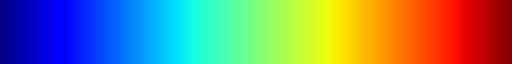

In [29]:
cmap = cm.jet
cmap

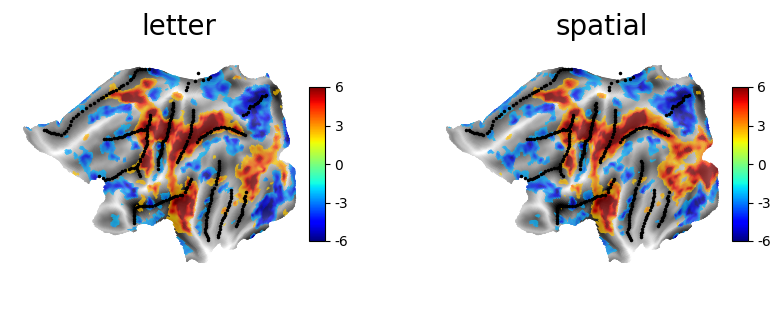

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, sss in enumerate(['letter','spatial']):
    ax=axs[ii]
    plt.sca(ax)
    res = scipy.stats.ttest_1samp(dataset[sss], popmean=0, axis=0)
    thresh = su.convert_alpha_to_tval(alpha=0.05, df=res.df.mean())
    data = res.statistic
    # data = scipy.ndimage.gaussian_filter(data, sigma=0.6)
    g = surf.plot.plotmap(
        data=data,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-6,6],
        threshold=[-thresh,thresh],
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=40, y=250, s=sss, ha='center', va='center', fontsize=20)

### 1. Letter t-map

In [31]:
vmin, vmax = -10, 10

In [32]:
result_L = scipy.stats.ttest_1samp(dataset['letter'], popmean=0, axis=0)
thresh = su.convert_alpha_to_tval(alpha=0.01, df=result_L.df.mean())

In [33]:
result_L.statistic

array([ 3.72371755, -1.15971197,  4.30740934, ...,  0.27919267,
       -0.03106658,  0.06537501])

(65.0, 66.0)

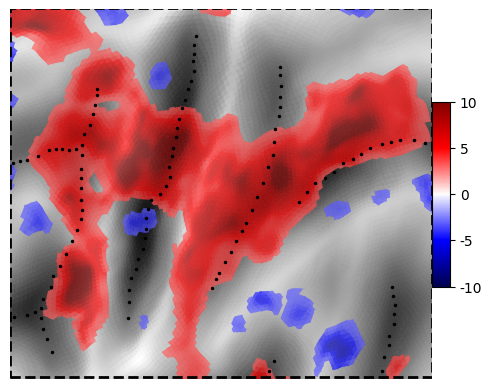

In [34]:
data = np.copy(result_L.statistic)
# data = scipy.ndimage.gaussian_filter(data, sigma=0.75)
data[np.abs(result_L.statistic)<thresh] = np.nan
g = surf.plot.plotmap(
    data=data,
    surf='fs32k_L',
    alpha=0.7,
    cmap=cm.seismic, colorbar=True, cscale=[vmin,vmax],
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)
rect = patches.Rectangle(
    xy=(-40, -4), width=160, height=140,
    linewidth=2, edgecolor='k', facecolor='none', linestyle='--'
)
g.add_patch(rect)
g.set_xlim(-40,120)
g.set_ylim(65,66)

### 2. Spatial t-map

In [35]:
result_S = scipy.stats.ttest_1samp(dataset['spatial'], popmean=0, axis=0)
thresh = su.convert_alpha_to_tval(alpha=0.01, df=result_S.df.mean())

(65.0, 66.0)

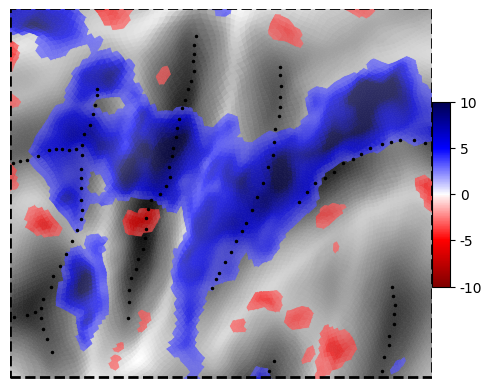

In [36]:
data = np.copy(result_S.statistic)
# data = scipy.ndimage.gaussian_filter(data, sigma=0.75)
data[np.abs(result_S.statistic)<thresh] = np.nan
g = surf.plot.plotmap(
    data=data,
    surf='fs32k_L',
    alpha=0.7,
    cmap=cm.seismic_r, colorbar=True, cscale=[vmin,vmax],
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)
rect = patches.Rectangle(
    xy=(-40, -4), width=160, height=140,
    linewidth=2, edgecolor='k', facecolor='none', linestyle='--'
)
g.add_patch(rect)
g.set_xlim(-40,120)
g.set_ylim(65,66)

### 3. Overlap t-map

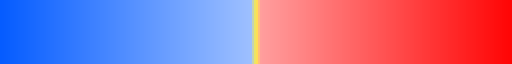

In [37]:
color = [
    (0, '#055CFF'),
    (0.49, '#9EC0FF'),
    (0.5, '#FFEF42'),
    (0.51, '#FF9E9E'),
    (1, '#FF0505')
]
cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', color)
# cmap = sns.color_palette("Spectral", as_cmap=True)
cmap

In [38]:
data = np.ones(32492) * np.nan

## Letter
idx_L = np.abs(result_L.statistic)>thresh
data[idx_L] = result_L.statistic[idx_L]

## Spatial
idx_S = np.abs(result_S.statistic)>thresh
data[idx_S] = -result_S.statistic[idx_S]

## Overlap|
idx = idx_L * idx_S
data[idx] = 0

(55.0, 70.0)

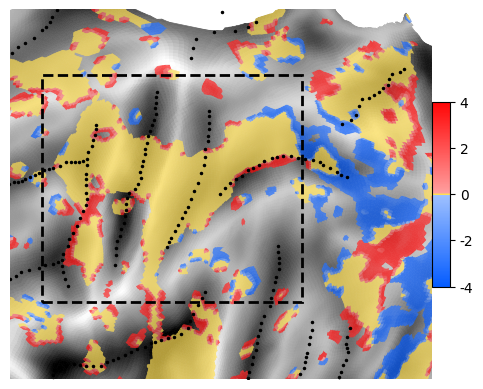

In [39]:
g = surf.plot.plotmap(
    data=data,
    surf='fs32k_L',
    alpha=0.7,
    cmap=cmap, colorbar=True, cscale=[-4,4],
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)
rect = patches.Rectangle(
    xy=(-40, -4), width=160, height=140,
    linewidth=2, edgecolor='k', facecolor='none', linestyle='--'
)
g.add_patch(rect)
g.set_xlim(-60,200)
g.set_ylim(55,70)